In [10]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Dataset: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation.

Download and unzip in ./data folder.

In [11]:
# ----------- Configuration -----------
IMG_SIZE = 128
VOLUME_START_AT = 60
VOLUME_SLICES = 75
DATA_PATH = "./data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
SAVE_DIR = "./data"

In [12]:
# ----------- Get patient IDs -----------
# samples = [s for s in os.listdir(DATA_PATH) if "BraTS20" in s]
samples = [
    s for s in os.listdir(DATA_PATH)
    if "BraTS20" in s and s != "BraTS20_Training_355"
]
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

In [13]:
print(f"Train: {len(samples_train)} | Val: {len(samples_val)} | Test: {len(samples_test)}")

Train: 249 | Val: 74 | Test: 45


In [ ]:
# def crop_to_foreground(img, margin=5):
#     if np.max(img) == 0:
#         return img  # return as-is if blank
#     img_bin = img > 0
#     coords = cv2.findNonZero(img_bin.astype(np.uint8))
#     x, y, w, h = cv2.boundingRect(coords)
#     x = max(x - margin, 0)
#     y = max(y - margin, 0)
#     w = min(w + 2 * margin, img.shape[1] - x)
#     h = min(h + 2 * margin, img.shape[0] - y)
#     return img[y:y+h, x:x+w]

def get_foreground_crop_coords(img, margin=5):
    """Return crop coordinates [y1, y2, x1, x2] that trim black borders."""
    if np.max(img) == 0:
        return 0, img.shape[0], 0, img.shape[1]
    
    img_bin = img > 0
    coords = cv2.findNonZero(img_bin.astype(np.uint8))
    x, y, w, h = cv2.boundingRect(coords)
    x1 = max(x - margin, 0)
    y1 = max(y - margin, 0)
    x2 = min(x + w + margin, img.shape[1])
    y2 = min(y + h + margin, img.shape[0])
    return y1, y2, x1, x2

# ----------- Load and preprocess data -----------
# def process_samples(sample_list, plot_example=False):
    
#     X_all = []
#     y_all = []
    
#     for i, pid in enumerate(tqdm(sample_list)):
#         prefix = os.path.join(DATA_PATH, pid, pid)
#         flair = nib.load(prefix + "_flair.nii").get_fdata()
#         t1ce = nib.load(prefix + "_t1ce.nii").get_fdata()
#         t2 = nib.load(prefix + "_t2.nii").get_fdata()
#         seg = nib.load(prefix + "_seg.nii").get_fdata()

#         for j in range(VOLUME_SLICES):
#             flair_slice = flair[:, :, j + VOLUME_START_AT]
#             t1ce_slice = t1ce[:, :, j + VOLUME_START_AT]
#             seg_slice = seg[:, :, j + VOLUME_START_AT]
#             t2_slice = t2[:, :, j + VOLUME_START_AT]

#             # # Resize slices
#             # flair_resized = cv2.resize(flair_slice, (IMG_SIZE, IMG_SIZE))
#             # t1ce_resized = cv2.resize(t1ce_slice, (IMG_SIZE, IMG_SIZE))
#             # t2_resized = cv2.resize(t2_slice, (IMG_SIZE, IMG_SIZE))
#             # seg_resized = cv2.resize(seg_slice, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

#             # # Crop each slice before resizing
#             # flair_crop = crop_to_foreground(flair_slice)
#             # t1ce_crop = crop_to_foreground(t1ce_slice)
#             # t2_crop = crop_to_foreground(t2_slice)
#             # seg_crop = crop_to_foreground(seg_slice)

#             # --- Determine crop coordinates from FLAIR
#             y1, y2, x1, x2 = get_foreground_crop_coords(flair_slice)

#             # --- Apply same crop to all modalities and seg
#             flair_crop = flair_slice[y1:y2, x1:x2]
#             t1ce_crop = t1ce_slice[y1:y2, x1:x2]
#             t2_crop   = t2_slice[y1:y2, x1:x2]
#             seg_crop  = seg_slice[y1:y2, x1:x2]

#             # --- Resize all to fixed IMG_SIZE
#             flair_resized = cv2.resize(flair_crop, (IMG_SIZE, IMG_SIZE))
#             t1ce_resized  = cv2.resize(t1ce_crop,  (IMG_SIZE, IMG_SIZE))
#             t2_resized    = cv2.resize(t2_crop,    (IMG_SIZE, IMG_SIZE))
#             seg_resized   = cv2.resize(seg_crop,   (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

#             # Resize
#             flair_resized = cv2.resize(flair_crop, (IMG_SIZE, IMG_SIZE))
#             t1ce_resized = cv2.resize(t1ce_crop, (IMG_SIZE, IMG_SIZE))
#             t2_resized = cv2.resize(t2_crop, (IMG_SIZE, IMG_SIZE))
#             seg_resized = cv2.resize(seg_crop, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

#             # Reassign label 4 to 3
#             seg_resized[seg_resized == 4] = 3

#             # Normalize
#             x = np.stack([flair_resized, t1ce_resized, t2_resized], axis=0)
#             x_max = np.max(x)
#             x = x / x_max if x_max > 0 else x

#             X_all.append(torch.tensor(x, dtype=torch.float32))
#             y_all.append(torch.tensor(seg_resized, dtype=torch.long))

#             # Plot only once
#             if i == 0 and j == 0 and plot_example:
#                 # Save slices for plotting
#                 flair_plot = flair_resized
#                 t1ce_plot = t1ce_resized
#                 t2_plot = t2_resized
#                 seg_plot = seg_resized


#                 # --- Show FLAIR, T1CE, T2 side-by-side
#                 fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#                 axs[0].imshow(flair_plot, cmap='gray')
#                 axs[0].set_title(f'FLAIR ({IMG_SIZE}x{IMG_SIZE})')
#                 axs[1].imshow(t1ce_plot, cmap='gray')
#                 axs[1].set_title(f'T1CE ({IMG_SIZE}x{IMG_SIZE})')
#                 axs[2].imshow(t2_plot, cmap='gray')
#                 axs[2].set_title(f'T2 ({IMG_SIZE}x{IMG_SIZE})')
#                 plt.show()

#                 # --- Show segmentation masks for each class
#                 fig, axs = plt.subplots(1, 5, figsize=(20, 4))
#                 class_labels = ['All', 'Class 0 (NT)', 'Class 1 (NCR/NET)', 'Class 2 (ED)', 'Class 3 (ET)']
#                 axs[0].imshow(seg_plot, cmap='tab10')
#                 axs[0].set_title('Segmentation (all)')

#                 for k in range(4):
#                     mask = np.where(seg_plot == k, k, np.nan)
#                     axs[k + 1].imshow(mask, cmap='tab10', vmin=0, vmax=3)
#                     axs[k + 1].set_title(class_labels[k + 1])

#                 for ax in axs:
#                     ax.axis('off')
#                 plt.tight_layout()
#                 plt.show()
#                 plt.close()

#     return torch.stack(X_all), torch.stack(y_all)

def process_samples(sample_list, plot_example=False):
    X_all = []
    y_all = []

    for i, pid in enumerate(tqdm(sample_list)):
        prefix = os.path.join(DATA_PATH, pid, pid)
        flair = nib.load(prefix + "_flair.nii").get_fdata()
        t1ce = nib.load(prefix + "_t1ce.nii").get_fdata()
        t2 = nib.load(prefix + "_t2.nii").get_fdata()
        seg = nib.load(prefix + "_seg.nii").get_fdata()

        # print(f"{pid} shapes:")
        # print(f"  FLAIR full:     {flair.shape}")
        # axial_idx = flair.shape[2] // 2
        # coronal_idx = flair.shape[1] // 2
        # sagittal_idx = flair.shape[0] // 2
        # print(f"  FLAIR axial:    {flair[:, :, axial_idx].shape}")
        # print(f"  FLAIR coronal:  {flair[:, coronal_idx, :].shape}")
        # print(f"  FLAIR sagittal: {flair[sagittal_idx, :, :].shape}")
        # break  # Just show one example for debugging

        # Middle indices for each view
        axial_idx = 155 // 2
        coronal_idx = 240 // 2
        sagittal_idx = 240 // 2

        # --- Define slice extraction for each view
        views = [
            flair[:, :, axial_idx],     # Axial
            flair[:, coronal_idx, :],   # Coronal
            flair[sagittal_idx, :, :]   # Sagittal
        ]
        t1ce_views = [
            t1ce[:, :, axial_idx],
            t1ce[:, coronal_idx, :],
            t1ce[sagittal_idx, :, :]
        ]
        t2_views = [
            t2[:, :, axial_idx],
            t2[:, coronal_idx, :],
            t2[sagittal_idx, :, :]
        ]
        seg_views = [
            seg[:, :, axial_idx],
            seg[:, coronal_idx, :],
            seg[sagittal_idx, :, :]
        ]

        for v in range(3):
            # Crop coordinates from FLAIR
            y1, y2, x1, x2 = get_foreground_crop_coords(views[v])

            flair_crop = views[v][y1:y2, x1:x2]
            t1ce_crop = t1ce_views[v][y1:y2, x1:x2]
            t2_crop = t2_views[v][y1:y2, x1:x2]
            seg_crop = seg_views[v][y1:y2, x1:x2]

            # Resize
            flair_resized = cv2.resize(flair_crop, (IMG_SIZE, IMG_SIZE))
            t1ce_resized = cv2.resize(t1ce_crop, (IMG_SIZE, IMG_SIZE))
            t2_resized = cv2.resize(t2_crop, (IMG_SIZE, IMG_SIZE))
            seg_resized = cv2.resize(seg_crop, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            seg_resized[seg_resized == 4] = 3

            x = np.stack([flair_resized, t1ce_resized, t2_resized], axis=0)
            x_max = np.max(x)
            x = x / x_max if x_max > 0 else x

            X_all.append(torch.tensor(x, dtype=torch.float32))
            y_all.append(torch.tensor(seg_resized, dtype=torch.long))

            if i == 0 and v == 0 and plot_example:
                # Show sample only for the first axial view
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(flair_resized, cmap='gray')
                axs[1].imshow(t1ce_resized, cmap='gray')
                axs[2].imshow(t2_resized, cmap='gray')
                plt.show()

                fig, axs = plt.subplots(1, 5, figsize=(20, 4))
                axs[0].imshow(seg_resized, cmap='tab10')
                for k in range(4):
                    mask = np.where(seg_resized == k, k, np.nan)
                    axs[k + 1].imshow(mask, cmap='tab10', vmin=0, vmax=3)
                for ax in axs: ax.axis('off')
                plt.tight_layout()
                plt.show()
                plt.close()

    return torch.stack(X_all), torch.stack(y_all)

  0%|          | 0/249 [00:00<?, ?it/s]

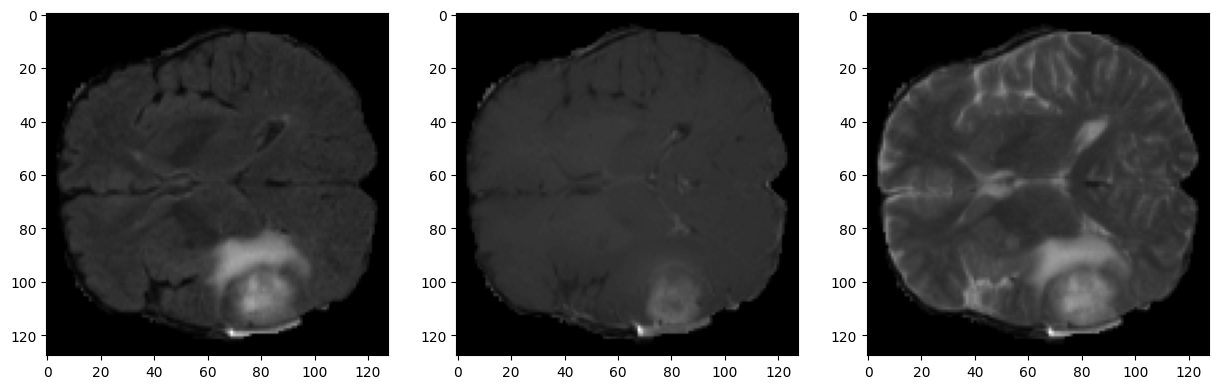

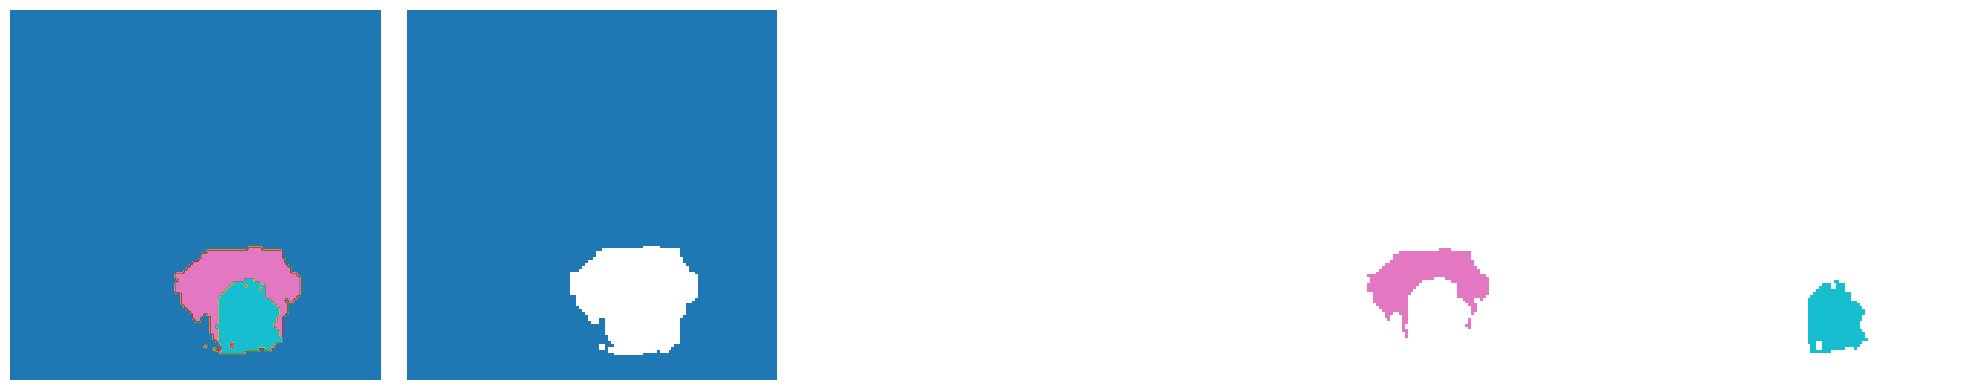

100%|██████████| 45/45 [00:22<00:00,  1.99it/s]


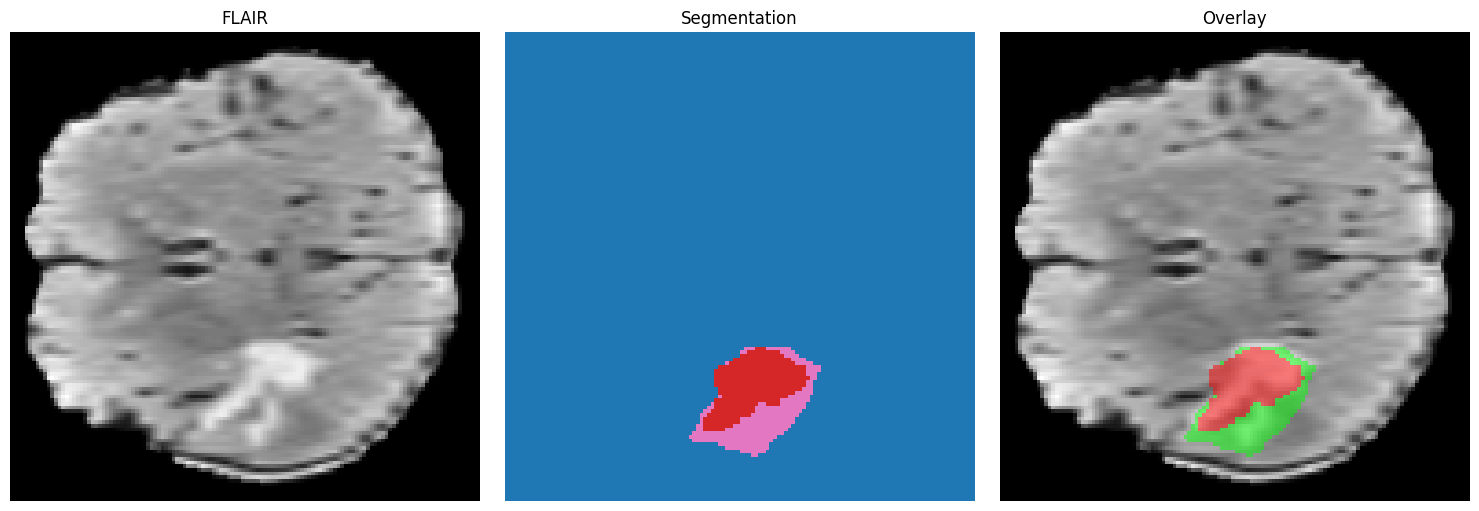

In [15]:
# ----------- Process and save datasets -----------
random.shuffle(samples_train)
X_train, y_train = process_samples(samples_train, plot_example=True)
X_val, y_val = process_samples(samples_val)
X_test, y_test = process_samples(samples_test)

def test_segmentation_alignment(x_tensor, y_tensor, slice_index=0, alpha=0.5):
    """
    Visual test to check that the segmentation mask aligns with the image.
    x_tensor: Tensor of shape (N, C=3, H, W)
    y_tensor: Tensor of shape (N, H, W)
    """
    import matplotlib.pyplot as plt

    img = x_tensor[slice_index].numpy()
    mask = y_tensor[slice_index].numpy()

    flair = img[0]  # (H, W)
    seg = mask      # (H, W)

    # Normalize FLAIR for display
    flair_norm = (flair - flair.min()) / (flair.max() - flair.min() + 1e-5)
    flair_rgb = np.stack([flair_norm]*3, axis=-1)

    # Create colored mask overlay
    overlay = flair_rgb.copy()
    overlay[seg == 1] = [1.0, 0.0, 0.0]  # Red for NCR/NET
    overlay[seg == 2] = [0.0, 1.0, 0.0]  # Green for ED
    overlay[seg == 3] = [0.0, 0.0, 1.0]  # Blue for ET
    blended = (1 - alpha) * flair_rgb + alpha * overlay

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(flair, cmap='gray')
    axs[0].set_title('FLAIR')
    axs[1].imshow(seg, cmap='tab10', vmin=0, vmax=3)
    axs[1].set_title('Segmentation')
    axs[2].imshow(blended)
    axs[2].set_title('Overlay')
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


test_segmentation_alignment(X_train, y_train, slice_index=123)

In [16]:
os.makedirs(SAVE_DIR, exist_ok=True)
torch.save((X_train, y_train), os.path.join(SAVE_DIR, "brats_train.pt"))
torch.save((X_val, y_val), os.path.join(SAVE_DIR, "brats_val.pt"))
torch.save((X_test, y_test), os.path.join(SAVE_DIR, "brats_test.pt"))